## Download MonoDepth2 Model

In [1]:
# Download monodepth2 model from official link
!wget -nc https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono_640x192.zip -O ../models/monodepth2/weights/mono_640x192.zip

# Unzip the downloaded model
!unzip -n ../models/monodepth2/weights/mono_640x192.zip -d ../models/monodepth2/weights/mono_640x192

File ‘../models/monodepth2/models/mono_640x192.zip’ already there; not retrieving.
Archive:  ../models/monodepth2/models/mono_640x192.zip


## Load Libraries

In [2]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import sys

from torchvision import transforms
from PIL import Image

In [3]:
sys.path.append("..")
from models.monodepth2.networks import ResnetEncoder, DepthDecoder

## Load Test Image

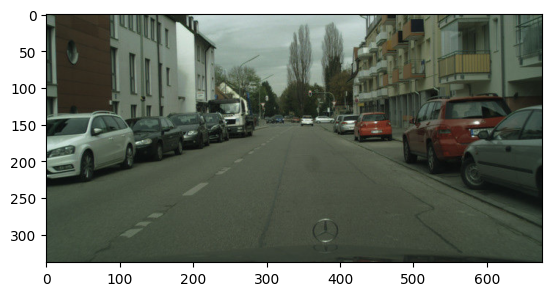

In [4]:
url = "https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png"
cityscape_img = np.array(Image.open(requests.get(url, stream=True).raw))

plt.imshow(cityscape_img)
plt.show()

## Load Model

In [5]:
model_name = "mono_640x192"
base_model_path = os.path.join("../adv_manhole/models/monodepth2/weights/")

encoder_path = os.path.join(base_model_path, model_name, "encoder.pth")
depth_decoder_path = os.path.join(base_model_path, model_name, "depth.pth")

In [6]:
# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location="cpu")
filtered_dict_enc = {
    k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()
}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location="cpu")
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()

print("Model loaded")

Model loaded


/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Put the model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
depth_decoder.to(device)

print(f"Moving model to {device}")

Moving model to cuda


In [8]:
def preprocess_mde(image, device):
    # Check if the image is not a tensor
    if not torch.is_tensor(image):
        # Convert the image to a tensor
        image = transforms.ToTensor()(image).unsqueeze(0)

    # Resize the image to the MDE input size
    image = transforms.Resize(
        (loaded_dict_enc["height"], loaded_dict_enc["width"]),
        interpolation=transforms.InterpolationMode.BILINEAR,
    )(image)

    image = image.to(device)

    return image


def predict_mde(tensor_imgs, original_shape):
    # PREDICTION
    features = encoder(tensor_imgs)
    outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(
        disp, original_shape, mode="bilinear", align_corners=False
    )
    return disp_resized


def plot_mde_results(image, disp_resized):
    # PLOTTING
    disp_resized_np = disp_resized.squeeze().cpu().detach().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(5, 5))
    plt.subplot(211)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap="magma", vmax=vmax)
    plt.title("Disparity")
    plt.axis("off")

    plt.show()

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


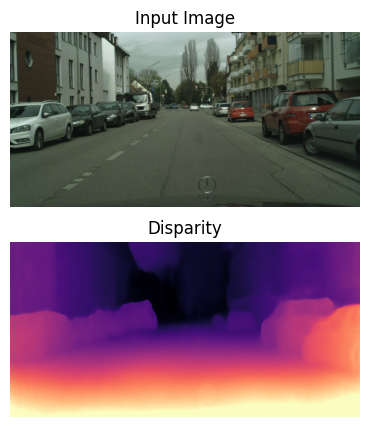

In [9]:
with torch.no_grad():
    tensor_imgs = preprocess_mde(cityscape_img, device)
    disp_resized = predict_mde(tensor_imgs, cityscape_img.shape[:2])

plot_mde_results(cityscape_img, disp_resized)